## Учебный проект (Предсказание оттока)

Целевая переменная находится в колонке `Cancellation Confirmation`

In [7]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import add_months, avg, count, countDistinct, col, datediff,\
desc, expr, from_unixtime, floor, isnan, lag, lit, month, months_between,\
min, max, split, sum, udf, unix_timestamp, when, year
from pyspark.sql.types import IntegerType, DateType
from pyspark.sql.window import Window

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, GBTClassifier, LinearSVC
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

from datetime import datetime

In [8]:
spark = SparkSession.builder.\
                     appName("best_one").\
                    master("spark://spark-master:7077").\
                    config("spark.executor.memory", "512m").\
                    getOrCreate()

# как посмотреть, что spark уже создан? Как обнаружить 

# Загрузка и обзор данных

In [9]:
df = spark.read.json('event_data_short.json')
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [10]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [ ]:
df.head()

Row(_corrupt_record='e":"Alexander","registration":1536817381000,"gender":"M","artist":"Intocable","song":"Tiempo","length":207.0722}', artist=None, auth=None, firstName=None, gender=None, itemInSession=None, lastName=None, length=None, level=None, location=None, method=None, page=None, registration=None, sessionId=None, song=None, status=None, ts=None, userAgent=None, userId=None)

In [ ]:
df.describe("ts").show()

+-------+--------------------+
|summary|                  ts|
+-------+--------------------+
|  count|              279402|
|   mean|1.541020348015104...|
| stddev|1.4723451594213476E9|
|    min|       1538374371000|
|    max|       1543799476000|
+-------+--------------------+



In [ ]:
ts = int(1538352117000)
ts /= 1000
print("Start Time: {}".format(datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S')))

ts = int(1543799476000)
ts /= 1000
print("End Time: {}".format(datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S')))

Start Time: 2018-10-01 00:01:57
End Time: 2018-12-03 01:11:16


# Обзор уникальных страниц в данных

In [ ]:
df.select("page").dropDuplicates().show()

# какие ещё способы, чтобы посмотреть только уникальные значения?

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|                null|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
| Submit Registration|
|            Settings|
|               Login|
|            Register|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
+--------------------+
only showing top 20 rows



In [ ]:
df.filter(df.page=="Cancel").show(4)

+---------------+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+------+-------------+---------+----+------+-------------+--------------------+------+
|_corrupt_record|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|  page| registration|sessionId|song|status|           ts|           userAgent|userId|
+---------------+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+------+-------------+---------+----+------+-------------+--------------------+------+
|           null|  null|Logged In|   Adriel|     M|          103| Mendoza|  null| paid|  Kansas City, MO-KS|   PUT|Cancel|1535623466000|      514|null|   307|1538943740000|"Mozilla/5.0 (Mac...|    18|
|           null|  null|Logged In|    Diego|     M|           55|   Mckee|  null| paid|Phoenix-Mesa-Scot...|   PUT|Cancel|1537167593000|      540|null|   307|1539033031000|"Mozilla/5.0 (iPh...|   

In [ ]:
df.filter(df.page=="Submit Downgrade").show(4)

+---------------+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+
|_corrupt_record|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|            page| registration|sessionId|song|status|           ts|           userAgent|userId|
+---------------+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+
|           null|  null|Logged In|  Kaylenn|     F|          354| Jenkins|  null| paid|           Price, UT|   PUT|Submit Downgrade|1535903878000|      479|null|   307|1538835479000|"Mozilla/5.0 (Mac...|   141|
|           null|  null|Logged In|    Colin|     M|          214| Freeman|  null| paid|     Bakersfield, CA|   PUT|Submit Downgrade|1538173362000|      532|

# Подготовка данных

In [ ]:
# собрать дата фрейм без пустых значений в -> firstName
df = df #

In [ ]:
# конвертирование timestamp в datetime 
adjust_timestamp = udf(lambda x : x//1000, IntegerType())
df = df.withColumn("ts_adj", adjust_timestamp('ts'))
df = df.withColumn("datetime", from_unixtime(col("ts_adj")))
df = df.withColumn("reg_adj", adjust_timestamp('registration'))
df = df.withColumn("reg_datetime", from_unixtime(col("reg_adj")))
df.show(5)

+---------------+---------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+-----------+-------------+---------+-------------------+------+-------------+--------------------+------+----------+-------------------+
|_corrupt_record|         artist|     auth|firstName|gender|itemInSession| lastName|   length|level|            location|method|       page| registration|sessionId|               song|status|           ts|           userAgent|userId|    ts_adj|           datetime|
+---------------+---------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+-----------+-------------+---------+-------------------+------+-------------+--------------------+------+----------+-------------------+
|           null|           null|Logged In|Alexander|     M|          254|   Garcia|     null| paid|Indianapolis-Carm...|   PUT|  Thumbs Up|1536817381000|      104|               null|   307|1538561062000|

In [ ]:
# удалить выбранные колонки
columns_to_drop = ['registration', 'ts', 'ts_adj', 'reg_adj']
df = df.drop(#)

In [ ]:
# добавим дату для точки отсчета (начальная дата анализа)
df = df.withColumn('analysis_start_date', lit('2018-10-01 00:00:00'))
df = df.withColumn("month_num", floor(months_between(df.datetime, df.analysis_start_date)))
df.show(2)

# EDA

In [ ]:
# функции для работы

def define_churn(x):
    """
    Разработка таргета,
    Определение оттока
    """
    if x == "Cancellation Confirmation":
        return 1
    elif x == "Submit Downgrade":
        return 1
    else:
        return 0

    
# в udf      
churn_event = udf(lambda x : define_churn(x), IntegerType())

In [ ]:
# замена данные в колонке
# free: 0, paid: 1
df = df.replace(["free", "paid"], ["0", "1"], "level")
# male: 0, female: 1
df = df.replace(["M", "F"], ["0", "1"], "gender")

In [ ]:
# применяем функцию определения оттока
# создать новую колонку, которая будет содержать целевое событие
df = df.#

In [ ]:
# сделаем обзор результата
df.select('month_num','churn').groupBy('month_num','churn').count().orderBy('month_num', 'churn').show()

In [ ]:
# несколько агрегатов (обычный способ генерации фич)
# какой способ ещё можно использовать (вы уже знаете про Feature Storage)???

df_register = df.select('userId', 'month_num', 'page') \
.where(df.page=="Register") \
.groupBy('userId', 'month_num') \
.agg({'page':'count'}) \
.withColumnRenamed('count(page)', 'numRegister')

df_cancel = df.select('userId', 'month_num', 'page') \
.where(df.page=="Cancel") \
.groupBy('userId', 'month_num') \
.agg({'page':'count'}) \
.withColumnRenamed('count(page)', 'numCancelVisits')

df_upgrade = df.select('userId', 'month_num', 'page') \
.where(df.page=="Upgrade") \
.groupBy('userId', 'month_num') \
.agg({'page':'count'}) \
.withColumnRenamed('count(page)', 'numUpgradeVisits')

df_downgrade = df.select('userId', 'month_num', 'page') \
.where(df.page=="Downgrade") \
.groupBy('userId', 'month_num') \
.agg({'page':'count'}) \
.withColumnRenamed('count(page)', 'numDowngradeVisits')

df_home = df.select('userId', 'month_num', 'page') \
.where(df.page=="Home") \
.groupBy('userId', 'month_num') \
.agg({'page':'count'}) \
.withColumnRenamed('count(page)', 'numHomeVisits')

df_about = df.select('userId', 'month_num', 'page') \
.where(df.page=="About") \
.groupBy('userId', 'month_num') \
.agg({'page':'count'}) \
.withColumnRenamed('count(page)', 'numAboutVisits')

df_settings = df.select('userId', 'month_num', 'page') \
.where(df.page=="Settings") \
.groupBy('userId', 'month_num') \
.agg({'page':'count'}) \
.withColumnRenamed('count(page)', 'numSettingsVisits')

df_saveSettings = df.select('userId', 'month_num', 'page') \
.where(df.page=="Save Settings") \
.groupBy('userId', 'month_num') \
.agg({'page':'count'}) \
.withColumnRenamed('count(page)', 'numSaveSettings')

df_login = df.select('userId', 'month_num', 'page') \
.where(df.page=="Login") \
.groupBy('userId', 'month_num') \
.agg({'page':'count'}) \
.withColumnRenamed('count(page)', 'numLogins')

df_logout = df.select('userId', 'month_num', 'page') \
.where(df.page=="Logout") \
.groupBy('userId', 'month_num') \
.agg({'page':'count'}) \
.withColumnRenamed('count(page)', 'numLogouts')

df_addPlaylist = df.select('userId', 'month_num', 'page') \
.where(df.page=="Add to Playlist") \
.groupBy('userId', 'month_num') \
.agg({'page':'count'}) \
.withColumnRenamed('count(page)', 'numAddPlaylists')

df_addFriend = df.select('userId', 'month_num', 'page') \
.where(df.page=="Add Friend") \
.groupBy('userId', 'month_num') \
.agg({'page':'count'}) \
.withColumnRenamed('count(page)', 'numFriends')

df_thumbsUp = df.select('userId', 'month_num', 'page') \
.where(df.page=="Thumbs Up") \
.groupBy('userId', 'month_num') \
.agg({'page':'count'}) \
.withColumnRenamed('count(page)', 'numThumbsUp')

df_thumbsDown = df.select('userId', 'month_num', 'page') \
.where(df.page=="Thumbs Down") \
.groupBy('userId', 'month_num') \
.agg({'page':'count'}) \
.withColumnRenamed('count(page)', 'numThumbsDown')

df_advert = df.select('userId', 'month_num', 'page') \
.where(df.page=="Roll Advert") \
.groupBy('userId', 'month_num') \
.agg({'page':'count'}) \
.withColumnRenamed('count(page)', 'numAdverts')

df_songsPlayed = df.select('userId', 'month_num', 'page') \
.where(df.page=="NextSong") \
.groupBy('userId', 'month_num') \
.agg({'page':'count'}) \
.withColumnRenamed('count(page)', 'numSongsPlayed')

df_totalListen = df.select('userId', 'month_num', 'length') \
.groupBy('userId', 'month_num') \
.agg({'length':'sum'}) \
.withColumnRenamed('sum(length)', 'totalListenTime')

df_songsPerSession = df.select('userId', 'month_num', 'page', 'sessionId') \
.where(df.page=="NextSong") \
.groupBy('userId', 'month_num', 'sessionId') \
.agg({'page':'count'}) \
.withColumnRenamed('count(page)', 'SongsPerSession')

df_avgSongsPerSession = df_songsPerSession.groupBy('userId', 'month_num') \
.agg(avg(df_songsPerSession.SongsPerSession).alias('avgSongsPerSession'))

df_singersPlayed = df.select('userId', 'month_num', 'page', 'artist') \
.where(df.page=="NextSong") \
.groupBy('userId', 'month_num') \
.agg(countDistinct(df.artist).alias('numSingersPlayed'))

df_singersPerSession = df.select('userId', 'month_num', 'page', 'artist', 'sessionId') \
.where(df.page=="NextSong") \
.groupBy('userId', 'month_num', 'sessionId') \
.agg(countDistinct(df.artist).alias('SingersPerSession'))

df_avgSingersPerSession = df_singersPerSession.groupBy('userId', 'month_num') \
.agg(avg(df_singersPerSession.SingersPerSession).alias('avgSingersPerSession'))


df_userSession = df.groupBy("userId", "month_num", "sessionId") \
.agg(((max(unix_timestamp(df.datetime))-min(unix_timestamp(df.datetime)))/60.0).alias('sessionTimeMins'))

df_avgUserSession = df_userSession.groupBy('userId', 'month_num').agg(avg(df_userSession.sessionTimeMins).alias('avgSessionMins'))


df_numSession = df.select('userId', 'month_num', 'sessionId').dropDuplicates() \
.groupby('userId', 'month_num').agg({'sessionId':'count'}) \
.withColumnRenamed('count(sessionId)', 'numSessions')


df_level = df.select('userId', 'month_num', 'level') \
.groupBy('userId', 'month_num') \
.agg({'level':'max'}) \
.withColumnRenamed('max(level)', 'level')

df_gender = df.select('userId', 'month_num', 'gender') \
.groupBy('userId', 'month_num') \
.agg({'gender':'max'}) \
.withColumnRenamed('max(gender)', 'gender')


df = df.withColumn("start_of_month", expr("add_months(analysis_start_date, month_num)"))

df = df.withColumn("daysSinceReg", datediff(df.start_of_month, df.reg_datetime))

df_daysReg = df.select('userId', 'month_num', 'daysSinceReg') \
.groupBy('userId', 'month_num') \
.agg(min(df.daysSinceReg).alias('daysSinceReg'))

df_churn = df.select('userId', 'month_num', 'churn') \
.groupBy('userId', 'month_num') \
.agg({'churn':'max'}) \
.withColumnRenamed('max(churn)', 'churn')

In [ ]:
# соединение в один набор
all_data = df_register.join(df_cancel, ['userId', 'month_num'], 'outer') \
.join(df_upgrade, ['userId', 'month_num'], 'outer') \
.join(df_downgrade, ['userId', 'month_num'], 'outer') \
.join(df_home, ['userId', 'month_num'], 'outer') \
.join(df_about, ['userId', 'month_num'], 'outer') \
.join(df_settings, ['userId', 'month_num'], 'outer') \
.join(df_saveSettings, ['userId', 'month_num'], 'outer') \
.join(df_login, ['userId', 'month_num'], 'outer') \
.join(df_logout, ['userId', 'month_num'], 'outer') \
.join(df_addPlaylist, ['userId', 'month_num'], 'outer') \
.join(df_addFriend, ['userId', 'month_num'], 'outer') \
.join(df_thumbsUp, ['userId', 'month_num'], 'outer') \
.join(df_thumbsDown, ['userId', 'month_num'], 'outer') \
.join(df_advert, ['userId', 'month_num'], 'outer') \
.join(df_songsPlayed, ['userId', 'month_num'], 'outer') \
.join(df_totalListen, ['userId', 'month_num'], 'outer') \
.join(df_avgSongsPerSession, ['userId', 'month_num'], 'outer') \
.join(df_singersPlayed, ['userId', 'month_num']) \
.join(df_avgSingersPerSession, ['userId', 'month_num'], 'outer') \
.join(df_avgUserSession, ['userId', 'month_num'], 'outer') \
.join(df_numSession, ['userId', 'month_num'], 'outer') \
.join(df_level, ['userId', 'month_num'], 'outer') \
.join(df_gender, ['userId', 'month_num'], 'outer') \
.join(df_daysReg, ['userId', 'month_num'], 'outer') \
.join(df_churn, ['userId', 'month_num'], 'outer')

In [ ]:
all_data.show(5)

In [ ]:
windowlag = #

# как использовать функцию LAG | LEAD ?
all_data = all_data.withColumn('numRegister_lastMonth', #

In [ ]:
# проверяем результат на 1 пользователе
all_data.filter(all_data.userId=="55").show()

In [ ]:
# как посчитать значение сумму по каждому новому параметру кумулятивно?

windowMov = #
# 
all_data = all_data.withColumn('numRegister_cum_old', 

In [ ]:
all_data.filter(all_data.userId=="55").show()

In [ ]:
# fill na/null
all_data = all_data.na.fill(0.0)

#### проблема визуализации
##### к сожалению, если вы не используете DataBricks, то вы вынуждены будете агрегировать и уменьшать данные для визуализации

In [ ]:
all_data_pd_1 = all_data \
.filter(all_data.month_num>=1) \
.select('numRegister_lastMonth','numCancelVisits_lastMonth',\
        'numUpgradeVisits_lastMonth', 'numDowngradeVisits_lastMonth',\
        'numHomeVisits_lastMonth', 'numAboutVisits_lastMonth',\
        'numSettingsVisits_lastMonth', 'numSaveSettings_lastMonth',\
        'numLogins_lastMonth', 'numLogouts_lastMonth',\
        'numAddPlaylists_lastMonth', 'numFriends_lastMonth',\
        'numThumbsUp_lastMonth', 'numThumbsDown_lastMonth',\
        'numAdverts_lastMonth',\
        'avgSongsPerSession_lastMonth',\
        'avgSingersPerSession_lastMonth',\
        'numSessions_lastMonth',\
        'daysSinceReg', 'churn'
        ) \
.groupBy('churn') \
.agg(avg(all_data.numRegister_lastMonth).alias('avgNumRegister_lastMonth'),\
     avg(all_data.numCancelVisits_lastMonth).alias('avgNumCancelVisits_lastMonth'),\
     avg(all_data.numUpgradeVisits_lastMonth).alias('avgNumUpgradeVisits_lastMonth'),\
     avg(all_data.numDowngradeVisits_lastMonth).alias('avgNumDowngradeVisits_lastMonth'),\
     avg(all_data.numHomeVisits_lastMonth).alias('avgNumHomeVisits_lastMonth'),\
     avg(all_data.numAboutVisits_lastMonth).alias('avgNumAboutVisits_lastMonth'),\
     avg(all_data.numSettingsVisits_lastMonth).alias('avgNumSettingsVisits_lastMonth'),\
     avg(all_data.numSaveSettings_lastMonth).alias('avgNumSaveSettings_lastMonth'),\
     avg(all_data.numLogins_lastMonth).alias('avgNumLogins_lastMonth'),\
     avg(all_data.numLogouts_lastMonth).alias('avgNumLogouts_lastMonth'),\
     avg(all_data.numAddPlaylists_lastMonth).alias('avgNumAddPlaylists_lastMonth'),\
     avg(all_data.numFriends_lastMonth).alias('avgNumFriends_lastMonth'),\
     avg(all_data.numThumbsUp_lastMonth).alias('avgNumThumbsUp_lastMonth'),\
     avg(all_data.numThumbsDown_lastMonth).alias('avgNumThumbsDown_lastMonth'),\
     avg(all_data.numAdverts_lastMonth).alias('avgNumAdverts_lastMonth'),\
     avg(all_data.avgSongsPerSession_lastMonth).alias('avgAvgSongsPerSession_lastMonth'),\
     avg(all_data.avgSingersPerSession_lastMonth).alias('avgAvgSingersPerSession_lastMonth'),\
     avg(all_data.numSessions_lastMonth).alias('avgNumSessions_lastMonth'),\
     avg(all_data.daysSinceReg).alias('avgDaysSinceReg'),\
    ).toPandas()

all_data_pd_2 = all_data \
.filter(all_data.month_num>=1) \
.select('numSongsPlayed_lastMonth',\
        'numSingersPlayed_lastMonth',\
        'avgSessionMins_lastMonth',\
        'churn'
       ) \
.groupBy('churn') \
.agg(avg(all_data.numSongsPlayed_lastMonth).alias('avgNumSongsPlayed_lastMonth'),\
     avg(all_data.numSingersPlayed_lastMonth).alias('avgNumSingersPlayed_lastMonth'),\
     avg(all_data.avgSessionMins_lastMonth).alias('avgAvgSessionMins_lastMonth')
    ).toPandas()

all_data_pd_3 = all_data \
.filter(all_data.month_num>=1) \
.select('totalListenTime_lastMonth', 'churn') \
.groupBy('churn') \
.agg(avg(all_data.totalListenTime_lastMonth).alias('avgTotalListenTime_lastMonth')).toPandas()

In [ ]:
all_data_pd_1.T

,0,1
churn,1.000000,0.000000
avgNumRegister_lastMonth,0.000000,0.000000
avgNumCancelVisits_lastMonth,0.000000,0.000000
avgNumUpgradeVisits_lastMonth,2.116279,1.189189
avgNumDowngradeVisits_lastMonth,8.441860,3.682432
avgNumHomeVisits_lastMonth,40.395349,19.891892
avgNumAboutVisits_lastMonth,1.953488,0.979730
avgNumSettingsVisits_lastMonth,5.372093,2.797297
avgNumSaveSettings_lastMonth,1.162791,0.533784
avgNumLogins_lastMonth,0.000000,0.000000


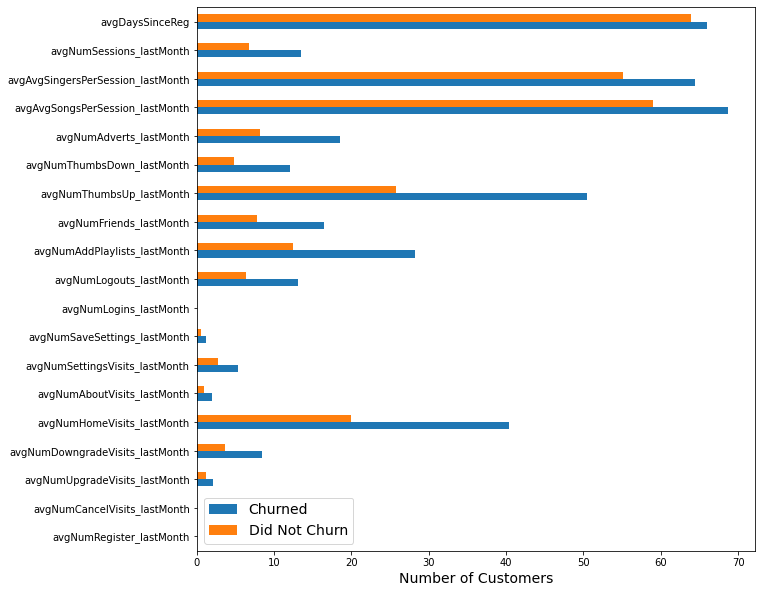

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
all_data_pd_1.drop('churn', axis=1).T.plot.barh(ax=ax);
ax.set_xlabel("Number of Customers", fontsize=14)
ax.legend(["Churned", "Did Not Churn"], fontsize=14);

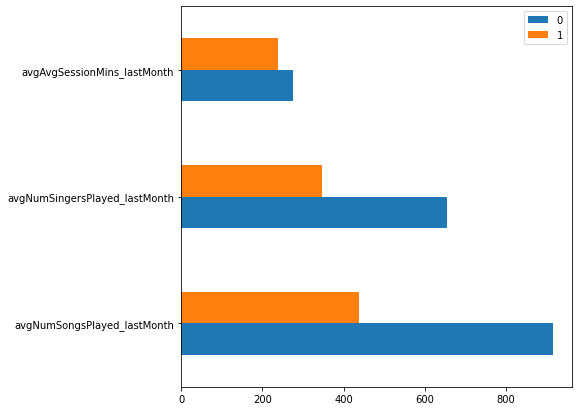

In [ ]:
all_data_pd_2.drop('churn', axis=1).T.plot.barh(figsize=(7,7));

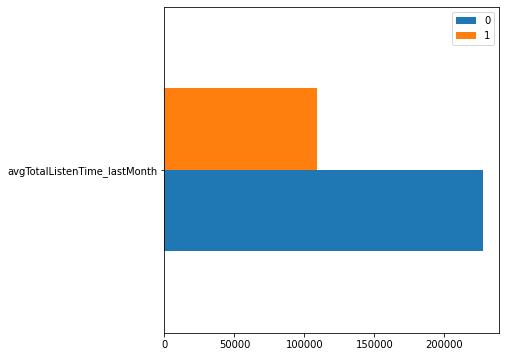

In [ ]:
all_data_pd_3.drop('churn', axis=1).T.plot.barh(figsize=(6,6));

# Feature Engineering

In [ ]:
# как оптимизировать такую конструкцию? 

all_data = all_data.withColumn('diff_numRegister', (all_data['numRegister_lastMonth'] - all_data['numRegister_movAvg']))
all_data = all_data.withColumn('diff_numCancelVisits', (all_data['numCancelVisits_lastMonth'] - all_data['numCancelVisits_movAvg']))
all_data = all_data.withColumn('diff_numUpgradeVisits', (all_data['numUpgradeVisits_lastMonth'] - all_data['numUpgradeVisits_movAvg']))
all_data = all_data.withColumn('diff_numDowngradeVisits', (all_data['numDowngradeVisits_lastMonth'] - all_data['numDowngradeVisits_movAvg']))
all_data = all_data.withColumn('diff_numHomeVisits', (all_data['numHomeVisits_lastMonth'] - all_data['numHomeVisits_movAvg']))
all_data = all_data.withColumn('diff_numAboutVisits', (all_data['numAboutVisits_lastMonth'] - all_data['numAboutVisits_movAvg']))
all_data = all_data.withColumn('diff_numSettingsVisits', (all_data['numSettingsVisits_lastMonth'] - all_data['numSettingsVisits_movAvg']))
all_data = all_data.withColumn('diff_numSaveSettings', (all_data['numSaveSettings_lastMonth'] - all_data['numSaveSettings_movAvg']))
all_data = all_data.withColumn('diff_numLogins', (all_data['numLogins_lastMonth'] - all_data['numLogins_movAvg']))
all_data = all_data.withColumn('diff_numLogouts', (all_data['numLogouts_lastMonth'] - all_data['numLogouts_movAvg']))
all_data = all_data.withColumn('diff_numAddPlaylists', (all_data['numAddPlaylists_lastMonth'] - all_data['numAddPlaylists_movAvg']))
all_data = all_data.withColumn('diff_numFriends', (all_data['numFriends_lastMonth'] - all_data['numFriends_movAvg']))
all_data = all_data.withColumn('diff_numThumbsUp', (all_data['numThumbsUp_lastMonth'] - all_data['numThumbsUp_movAvg']))
all_data = all_data.withColumn('diff_numThumbsDown', (all_data['numThumbsDown_lastMonth'] - all_data['numThumbsDown_movAvg']))
all_data = all_data.withColumn('diff_numAdverts', (all_data['numAdverts_lastMonth'] - all_data['numAdverts_movAvg']))
all_data = all_data.withColumn('diff_numSongsPlayed', (all_data['numSongsPlayed_lastMonth'] - all_data['numSongsPlayed_movAvg']))
all_data = all_data.withColumn('diff_totalListenTime', (all_data['totalListenTime_lastMonth'] - all_data['totalListenTime_movAvg']))
all_data = all_data.withColumn('diff_avgSongsPerSession', (all_data['avgSongsPerSession_lastMonth'] - all_data['avgSongsPerSession_movAvg']))
all_data = all_data.withColumn('diff_numSingersPlayed', (all_data['numSingersPlayed_lastMonth'] - all_data['numSingersPlayed_movAvg']))
all_data = all_data.withColumn('diff_avgSingersPerSession', (all_data['avgSingersPerSession_lastMonth'] - all_data['avgSingersPerSession_movAvg']))
all_data = all_data.withColumn('diff_avgSessionMins', (all_data['avgSessionMins_lastMonth'] - all_data['avgSessionMins_movAvg']))
all_data = all_data.withColumn('diff_numSessions', (all_data['numSessions_lastMonth'] - all_data['numSessions_movAvg']))

In [ ]:
# выбранные данные в чистловые значения
convert_numeric = ['userId', 'level', 'gender', 'level_lastMonth']
for feat in convert_numeric:
    featName = feat + "_n"
    all_data = all_data.withColumn(featName, all_data[feat].cast("float"))
    all_data = all_data.drop(feat)

In [ ]:
# fill na/null 
all_data = all_data.na.fill(0.0)

In [ ]:
### Мы сделали уже много шагов,что можно сделать, чтобы Spark считал быстрее?

In [ ]:
# spark.read.csv(out_path, header=True, inferSchema=True)
# all_data.persist()

# Modeling

In [ ]:
all_data.columns

['month_num',
 'numRegister',
 'numCancelVisits',
 'numUpgradeVisits',
 'numDowngradeVisits',
 'numHomeVisits',
 'numAboutVisits',
 'numSettingsVisits',
 'numSaveSettings',
 'numLogins',
 'numLogouts',
 'numAddPlaylists',
 'numFriends',
 'numThumbsUp',
 'numThumbsDown',
 'numAdverts',
 'numSongsPlayed',
 'totalListenTime',
 'avgSongsPerSession',
 'numSingersPlayed',
 'avgSingersPerSession',
 'avgSessionMins',
 'numSessions',
 'daysSinceReg',
 'churn',
 'numRegister_lastMonth',
 'numCancelVisits_lastMonth',
 'numUpgradeVisits_lastMonth',
 'numDowngradeVisits_lastMonth',
 'numHomeVisits_lastMonth',
 'numAboutVisits_lastMonth',
 'numSettingsVisits_lastMonth',
 'numSaveSettings_lastMonth',
 'numLogins_lastMonth',
 'numLogouts_lastMonth',
 'numAddPlaylists_lastMonth',
 'numFriends_lastMonth',
 'numThumbsUp_lastMonth',
 'numThumbsDown_lastMonth',
 'numAdverts_lastMonth',
 'numSongsPlayed_lastMonth',
 'totalListenTime_lastMonth',
 'avgSongsPerSession_lastMonth',
 'numSingersPlayed_lastMonth',

In [ ]:
# данные для модели
model_data = all_data \
.filter(all_data.month_num>0) \
.select('userId_n', 'month_num', 'numRegister_lastMonth', 'numCancelVisits_lastMonth',\
        'numUpgradeVisits_lastMonth', 'numDowngradeVisits_lastMonth',\
        'numHomeVisits_lastMonth', 'numAboutVisits_lastMonth',\
        'numSettingsVisits_lastMonth', 'numSaveSettings_lastMonth',\
        'numLogins_lastMonth', 'numLogouts_lastMonth', \
        'numAddPlaylists_lastMonth', 'numFriends_lastMonth',\
        'numThumbsUp_lastMonth', 'numThumbsDown_lastMonth',\
        'numAdverts_lastMonth', 'numSongsPlayed_lastMonth',\
        'totalListenTime_lastMonth', 'avgSongsPerSession_lastMonth',\
        'numSingersPlayed_lastMonth', 'avgSingersPerSession_lastMonth',\
        'avgSessionMins_lastMonth', 'numSessions_lastMonth',\
        'level_lastMonth_n', 'numRegister_movAvg', 'numCancelVisits_movAvg',\
        'numUpgradeVisits_movAvg', 'numDowngradeVisits_movAvg',\
        'numHomeVisits_movAvg', 'numAboutVisits_movAvg',\
        'numSettingsVisits_movAvg', 'numSaveSettings_movAvg',\
        'numLogins_movAvg', 'numLogouts_movAvg',\
        'numAddPlaylists_movAvg', 'numFriends_movAvg',\
        'numThumbsUp_movAvg', 'numThumbsDown_movAvg',\
        'numAdverts_movAvg', 'numSongsPlayed_movAvg',\
        'totalListenTime_movAvg', 'avgSongsPerSession_movAvg',\
        'numSingersPlayed_movAvg', 'avgSingersPerSession_movAvg',\
        'avgSessionMins_movAvg', 'numSessions_movAvg',\
        'diff_numRegister', 'diff_numCancelVisits',\
        'diff_numUpgradeVisits', 'diff_numDowngradeVisits',\
        'diff_numHomeVisits', 'diff_numAboutVisits',\
        'diff_numSettingsVisits', 'diff_numSaveSettings',\
        'diff_numLogins', 'diff_numLogouts',\
        'diff_numAddPlaylists', 'diff_numFriends',\
        'diff_numThumbsUp', 'diff_numThumbsDown',\
        'diff_numAdverts', 'diff_numSongsPlayed',\
        'diff_totalListenTime', 'diff_avgSongsPerSession',\
        'diff_numSingersPlayed', 'diff_avgSingersPerSession',
        'diff_avgSessionMins', 'diff_numSessions',\
        'gender_n', 'daysSinceReg', 'churn'
        ).withColumnRenamed('churn', 'label')

model_data.show(1)

In [ ]:
# как разделить выборку?
# какие ещё способы вы знаете?
train,test = model_data# 

In [ ]:
inputColumns = ['userId_n', 'month_num', 'numRegister_lastMonth', 'numCancelVisits_lastMonth',\
                'numUpgradeVisits_lastMonth', 'numDowngradeVisits_lastMonth',\
                'numHomeVisits_lastMonth', 'numAboutVisits_lastMonth',\
                'numSettingsVisits_lastMonth', 'numSaveSettings_lastMonth',\
                'numLogins_lastMonth', 'numLogouts_lastMonth', \
                'numAddPlaylists_lastMonth', 'numFriends_lastMonth',\
                'numThumbsUp_lastMonth', 'numThumbsDown_lastMonth',\
                'numAdverts_lastMonth', 'numSongsPlayed_lastMonth',\
                'totalListenTime_lastMonth', 'avgSongsPerSession_lastMonth',\
                'numSingersPlayed_lastMonth', 'avgSingersPerSession_lastMonth',\
                'avgSessionMins_lastMonth', 'numSessions_lastMonth',\
                'level_lastMonth_n', 'gender_n', 'daysSinceReg']


# фичи из колонок в вектор
assembler = VectorAssembler(inputCols=inputColumns, #)
                            
# скалируем все фичи. А что ещё можно применить? 
# не забудьте, что при сохранении моделей, все обработчики и трасформаторы должны быть сохранены.
# на train - учимся, применяем на всех
scaler = StandardScaler(inputCol="FeaturesVec", outputCol="features", withMean=True, withStd=True)


# базовый набор моделей
# Logistic Regression
lr=LogisticRegression(maxIter=30)
pipeline_lr = Pipeline(stages=[assembler, scaler, lr])

# Support Vector Machine Classifier
svc = LinearSVC(maxIter=30)
pipeline_svc = Pipeline(stages=[assembler, scaler, svc])

# Gradient Boosted Trees
gbt = GBTClassifier(maxIter=20, seed=42)
pipeline_gbt = Pipeline(stages=[assembler, scaler, gbt])

In [ ]:
# logistic Regression
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam,[0.0, 0.05]) \
    .build()

cv_lr = CrossValidator(estimator=pipeline_lr,\
                       estimatorParamMaps=paramGrid,\
                       evaluator=MulticlassClassificationEvaluator(),\
                       numFolds=5,\
                       seed=42
                      )

cvModel_lr = cv_lr.fit(train)
lr_results = cvModel_lr.transform(test)

evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print("Logistic Regression Model --- Accuracy is: ")
print(evaluator.evaluate(lr_results, {evaluator.metricName: "accuracy"}))
print("Logistic Regression Model --- F1-Score is: ")
print(evaluator.evaluate(lr_results, {evaluator.metricName: "f1"}))

In [ ]:
# Linear Support Vector Machine
paramGrid = ParamGridBuilder() \
    .addGrid(svc.regParam,[0.0, 0.05]) \
    .build()

cv_svc = CrossValidator(estimator=pipeline_svc,\
                       estimatorParamMaps=paramGrid,\
                       evaluator=MulticlassClassificationEvaluator(),\
                       numFolds=5,\
                       seed=42
                      )

cvModel_svc = cv_svc.fit(train)
svc_results = cvModel_svc.transform(test)
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print("Linear SVC Model --- Accuracy is: ")
print(evaluator.evaluate(svc_results, {evaluator.metricName: "accuracy"}))
print("Linear SVC Model --- F1-Score is: ")
print(evaluator.evaluate(svc_results, {evaluator.metricName: "f1"}))

In [ ]:
# Gradient Boosted Trees
paramGrid = ParamGridBuilder() \
            .addGrid(gbt.minInstancesPerNode,[1, 5, 10, 20, 50]) \
            .addGrid(gbt.maxDepth,[5, 7, 9])\
            .addGrid(gbt.subsamplingRate,[0.5,0.75,1.0])\
            .build()

cv_gbt = CrossValidator(estimator=pipeline_gbt,\
                        estimatorParamMaps=paramGrid,\
                        evaluator=MulticlassClassificationEvaluator(),\
                        numFolds=5,\
                        seed=42
                       )
cvModel_gbt = cv_gbt.fit(train)
gbt_results = cvModel_gbt.transform(test)
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print("GBT Model --- Accuracy is: ")
print(evaluator.evaluate(gbt_results, {evaluator.metricName: "accuracy"}))
print("GBT Model --- F1-Score is: ")
print(evaluator.evaluate(gbt_results, {evaluator.metricName: "f1"}))

In [ ]:
# соберем таблицу метрика-параметры по модели cvModel_gbt

# пример получения параметров по модели - cvModel_gbt
params = [{p.name: v for p, v in m.items()} for m in cvModel_gbt.getEstimatorParamMaps()]

pd.DataFrame.from_dict([
    {cvModel_gbt.getEvaluator().getMetricName(): metric, **ps} 
    for ps, metric in zip(params, cvModel_gbt.avgMetrics)
])

,f1,minInstancesPerNode,maxDepth,subsamplingRate
0,0.731607,1,5,0.50
1,0.796980,1,5,0.75
2,0.815278,1,5,1.00
3,0.745165,1,7,0.50
4,0.793815,1,7,0.75
5,0.804464,1,7,1.00
6,0.737742,1,9,0.50
7,0.793582,1,9,0.75
8,0.804464,1,9,1.00
9,0.811325,5,5,0.50


In [ ]:
# важность параметров в модели (фичей)
importances = cvModel_gbt.bestModel.stages[-1].featureImportances.toArray()
features = ['userId_n', 'month_num', 'numRegister_lastMonth', 'numCancelVisits_lastMonth',\
            'numUpgradeVisits_lastMonth', 'numDowngradeVisits_lastMonth',\
            'numHomeVisits_lastMonth', 'numAboutVisits_lastMonth',\
            'numSettingsVisits_lastMonth', 'numSaveSettings_lastMonth',\
            'numLogins_lastMonth', 'numLogouts_lastMonth', \
            'numAddPlaylists_lastMonth', 'numFriends_lastMonth',\
            'numThumbsUp_lastMonth', 'numThumbsDown_lastMonth',\
            'numAdverts_lastMonth', 'numSongsPlayed_lastMonth',\
            'totalListenTime_lastMonth', 'avgSongsPerSession_lastMonth',\
            'numSingersPlayed_lastMonth', 'avgSingersPerSession_lastMonth',\
            'avgSessionMins_lastMonth', 'numSessions_lastMonth',\
            'level_lastMonth_n', 'gender_n', 'daysSinceReg']

y_pos = np.arange(len(features))
    
fig, ax = plt.subplots(figsize=(10,8))
ax.barh(y_pos, importances);
plt.yticks(y_pos, features);
plt.xlabel('Importance Score');
plt.title('GBT Feature Importances');

[VectorAssembler_4b47e8300c7a,
 StandardScalerModel: uid=StandardScaler_b248631ff310, numFeatures=27, withMean=true, withStd=true,
 GBTClassificationModel: uid = GBTClassifier_f83845f26375, numTrees=20, numClasses=2, numFeatures=27]